In [29]:
#### Reference paper https://arxiv.org/abs/1808.08219




import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)




def y_fdm(gamma, y_i):
    solutions = []
    turnaround_points = []
    for y_i in yi_values:
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        tau_arr = np.geomspace(tau_i, tau_f, 10000)
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))
        if sol.t_events[0].size > 0:
            tau_ta = sol.t_events[0][0]
            y_ta = sol.y_events[0][0][0]
            turnaround_points.append(( y_i, tau_ta, y_ta))  
    return solutions, turnaround_points







def yta_true_min(gamma, initial_y_i):
    y_i = initial_y_i
    prev_y_ta = None
    prev_tau_ta = None
    tolerance = 1e-4  
    changed = False  
    while True:
        solutions, turnaround_points = y_fdm(gamma, [y_i])
        if not turnaround_points:
            break
        
        tau_ta, y_ta, _ = min(turnaround_points, key=lambda x: x[1])  
        if prev_y_ta is not None and np.isclose(y_ta, prev_y_ta, rtol=tolerance):
            break  
        prev_y_ta = y_ta
        prev_tau_ta = tau_ta
        y_i *= 0.9 
        changed = True  

    while changed:
        new_y_i = y_i * 0.99
        solutions, turnaround_points = y_fdm(gamma, [new_y_i])
        if not turnaround_points:
            break  
        tau_ta, y_ta, _ = min(turnaround_points, key=lambda x: x[1])  
        if np.isclose(y_ta, prev_y_ta, rtol=tolerance):
            break  
        prev_y_ta = y_ta
        prev_tau_ta = tau_ta
        y_i = new_y_i 
    print(gamma, y_i, prev_tau_ta, prev_y_ta)
    return gamma, y_i, prev_tau_ta, prev_y_ta


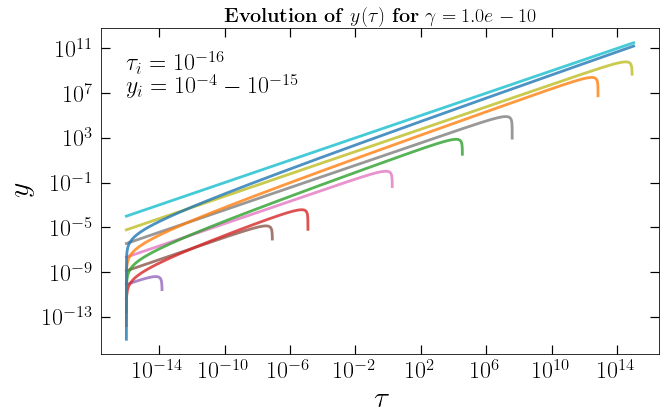

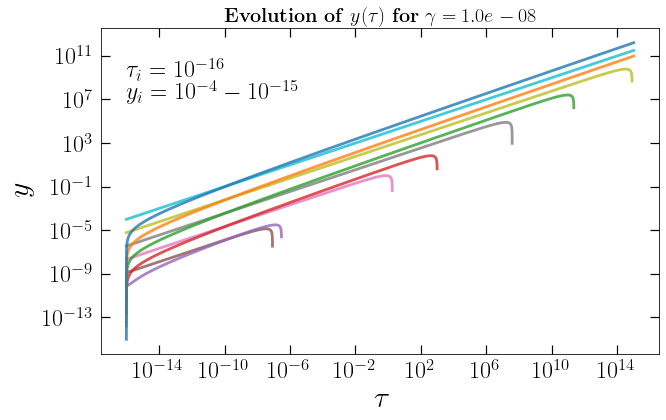

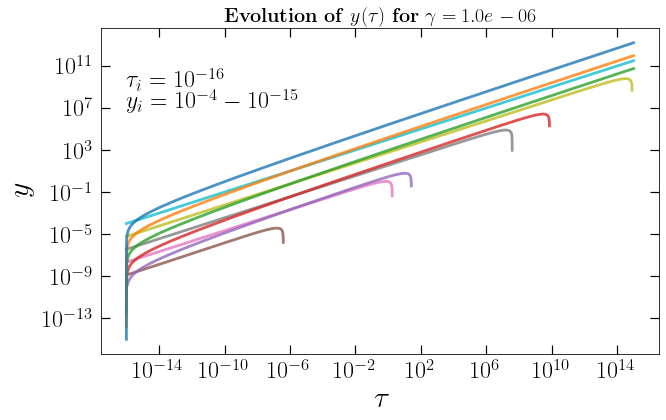

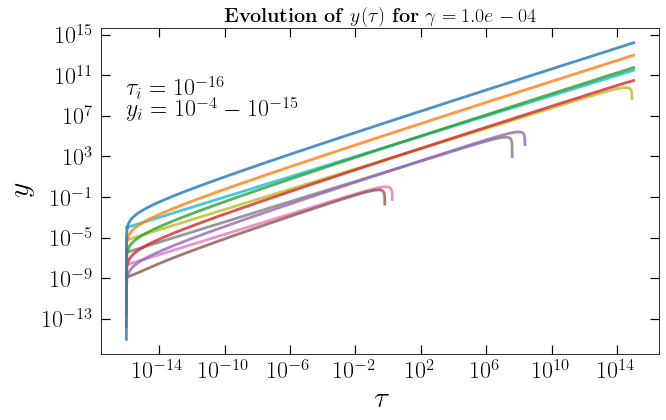

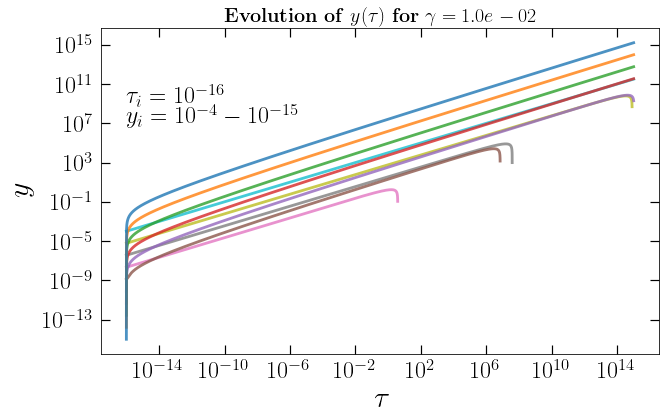

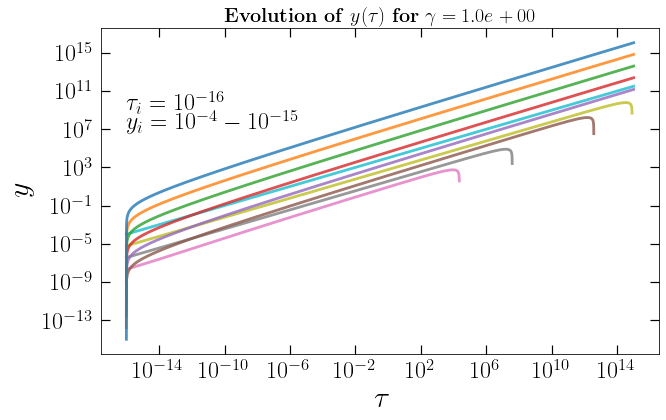

1e-10 6.96837314413015e-11 7.742636826811278e-11 6.2100323390131555e-15
1e-08 1.1623946985133943e-09 1.2915496650148826e-09 3.418421333428915e-08
1e-06 1.1623946985133943e-09 1.2915496650148826e-09 1.581352271250598e-07
0.0001 1.1623946985133943e-09 1.2915496650148826e-09 0.255852335934327
0.01 1.938991221028694e-08 2.1544346900318822e-08 1.5426406123941938
1.0 1.938991221028694e-08 2.1544346900318822e-08 9030.931022776384


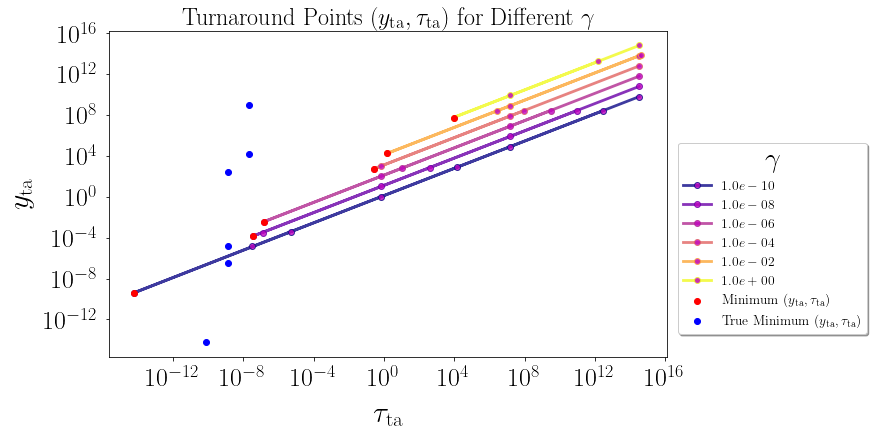

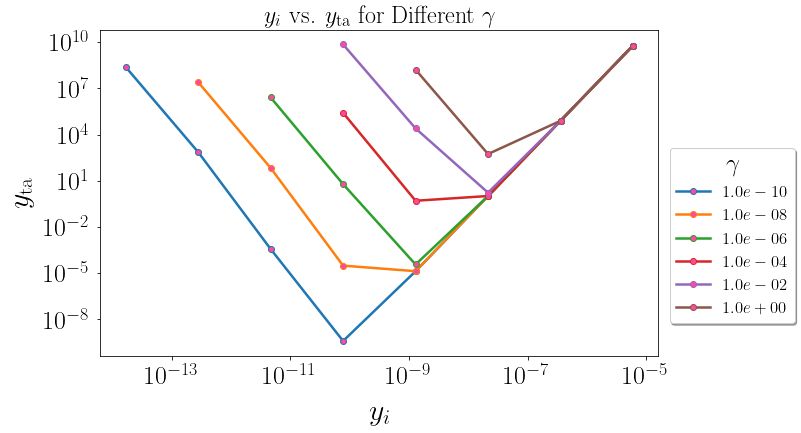

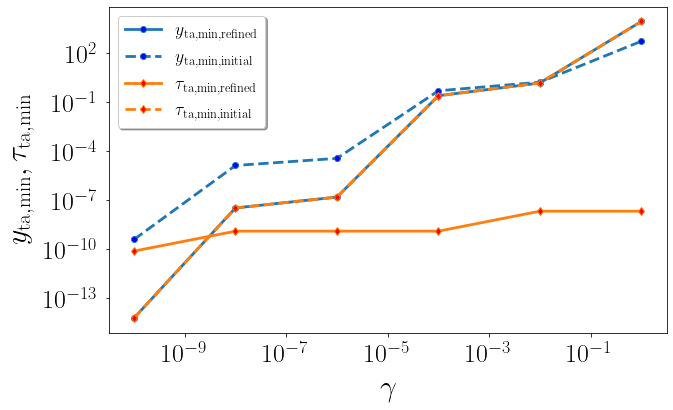


Initial minimum turnaround points:
Gamma: 1.0e-10, Y_i: 7.7426e-11, Tau_ta: 6.2100e-15, Y_ta: 4.0057e-10
Gamma: 1.0e-08, Y_i: 1.2915e-09, Tau_ta: 3.4184e-08, Y_ta: 1.3644e-05
Gamma: 1.0e-06, Y_i: 1.2915e-09, Tau_ta: 1.5814e-07, Y_ta: 3.7167e-05
Gamma: 1.0e-04, Y_i: 1.2915e-09, Tau_ta: 2.5585e-01, Y_ta: 5.1205e-01
Gamma: 1.0e-02, Y_i: 2.1544e-08, Tau_ta: 1.5426e+00, Y_ta: 1.7205e+00
Gamma: 1.0e+00, Y_i: 2.1544e-08, Tau_ta: 9.0309e+03, Y_ta: 5.5363e+02

Refined minimum turnaround points:
Gamma: 1.0e-10, Y_i: 6.9684e-11, Tau_ta: 7.7426e-11, Y_ta: 6.2100e-15
Gamma: 1.0e-08, Y_i: 1.1624e-09, Tau_ta: 1.2915e-09, Y_ta: 3.4184e-08
Gamma: 1.0e-06, Y_i: 1.1624e-09, Tau_ta: 1.2915e-09, Y_ta: 1.5814e-07
Gamma: 1.0e-04, Y_i: 1.1624e-09, Tau_ta: 1.2915e-09, Y_ta: 2.5585e-01
Gamma: 1.0e-02, Y_i: 1.9390e-08, Tau_ta: 2.1544e-08, Y_ta: 1.5426e+00
Gamma: 1.0e+00, Y_i: 1.9390e-08, Tau_ta: 2.1544e-08, Y_ta: 9.0309e+03


In [30]:
# Now, we want to verify that for a given value of gamma,
# whether the minimum values of yta_numerical and tau_ta_numerical are properly 
# identified or not.
# This will verify the validity of y_ta_min vs y_i plots.



gamma_values = np.geomspace(1e-10, 1, 6) 
yi_values = np.geomspace(1e-4, 1e-15, 10)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  




min_turnaround_pts = []
gamma_results = {}

for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [min(turnaround, key=lambda x: x[1]) for _, turnaround in gamma_results[gamma].values() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))


        
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i
for gamma in gamma_values:
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    solutions, all_turnaround_points = y_fdm(gamma, yi_values)

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    solutions, turnaround_points = y_fdm(gamma, yi_values)
    yi_ta, tau_ta, y_ta = zip(*turnaround_points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)


    

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)

                                 
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', zorder=10, label=" True Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

#plt.text(1e-13, 1e7, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
#plt.text(1e-13, 1e10, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta3.pdf", bbox_inches='tight')
plt.show()





turnaround_points = []
#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    solutions, turnaround_points = y_fdm(gamma, yi_values)
    yi_ta, tau_ta, y_ta = zip(*turnaround_points)  
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
#plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta3.pdf", bbox_inches='tight')
plt.show()




min_turnaround_pts = [pt for pt in min_turnaround_pts if pt[2] is not None]
true_min_turnaround_pts = [pt for pt in true_min_turnaround_pts if pt[2] is not None]
gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)


fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.loglog(gamma_arr, true_min_yta_arr, marker='o', markersize=6, markerfacecolor='b', ls='-', color ='C0')
ax4.loglog(gamma_arr, min_yta_arr, marker='o', markersize=6, markerfacecolor='b', ls='--',  color ='C0')
ax4.loglog(gamma_arr, true_min_tauta_arr, marker='d', markersize=6, markerfacecolor='r', ls='-', color ='C1')
ax4.loglog(gamma_arr, min_tauta_arr, marker='d', markersize=6, markerfacecolor='r', ls='--', color ='C1')

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, refined}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, refined}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("ytamin_vs_gamma3.pdf", bbox_inches='tight')
plt.show()


print("\nInitial minimum turnaround points:")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\nRefined minimum turnaround points:")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")
  